# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

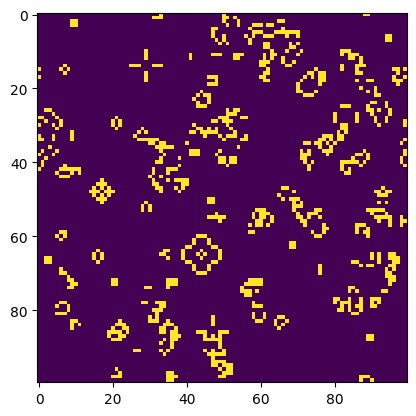

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ON = 255  # Alive cell value
OFF = 0   # Dead cell value
N = 100   # Size of the grid (N x N)

def update(frameNum, img, grid, N):
    newGrid = grid.copy()

    for i in range(N):
        for j in range(N):
            total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                         grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                         grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                         grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N]) / 255)

            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON

    img.set_data(newGrid)
    grid[:] = newGrid[:]
    return img

def save_frame(frameNum, img, grid, N):
    plt.savefig(f'gof_frame_{frameNum:03d}.png', format='png')
    return img

# Initialize a random grid
grid = np.random.choice([ON, OFF], N*N, p=[0.2, 0.8]).reshape(N, N)

# Set up the plot
fig, ax = plt.subplots()
img = ax.imshow(grid, interpolation='nearest')

# Set up the animation
ani = animation.FuncAnimation(fig, update, fargs=(img, grid, N,),
                              frames=50, interval=100,
                              init_func=lambda: save_frame(0, img, grid, N))

# To save the animation as a GIF using Pillow
ani.save('gof_animation.gif', writer='pillow', fps=5)

plt.show()